In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate
import statsmodels.api as sm
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import matplotlib.dates as mdates
import seaborn as sns

%matplotlib inline

In [7]:
os.chdir('/home1/10031/gracesstew/ACSC_SC25')

In [8]:
tour = pd.read_csv('data/all_tourist.csv')
tour.head()

,year_month,Visitors,Water Temperature (degF),Salinity (PSU),Turbidity (NTU),Chlorophyll (ug/L),Enterococcus (mpn/100mL)
0,2018-01,NaN,79.891204,31.723171,1.919315,3.220971,NaN
1,2018-02,"454,308",79.309341,31.119680,1.639482,2.639715,NaN
2,2018-03,"503,033",79.152026,31.250279,1.481051,2.529561,NaN
3,2018-04,"445,058",80.045995,31.349549,3.003634,2.544006,NaN
4,2018-05,"482,224",79.881787,32.353888,1.395863,4.219175,NaN


In [9]:
##table for N, mean , STD, range

#tour['Visitors'] = pd.to_numeric(tour['Visitors'], errors='coerce')

# select numeric columns
numeric_data = tour.select_dtypes(include='number')

# summary table
summary_table = pd.DataFrame({
    'N': numeric_data.count(),
    'Mean': numeric_data.mean(),
    'Std': numeric_data.std(),
    'Range': numeric_data.max() - numeric_data.min()
})

styled_table = (
    summary_table.style
    .set_table_styles([
        {'selector': 'th', 'props': [('background-color', '#f2f2f2'), ('text-align', 'center')]},
        {'selector': 'td', 'props': [('text-align', 'center')]},
    ])
    .set_properties(**{'border': '1px solid black', 'padding': '5px'})
)

styled_table

,N,Mean,Std,Range
Water Temperature (degF),90,79.793254,1.908892,8.296642
Salinity (PSU),90,33.009835,0.788929,3.639467
Turbidity (NTU),88,6.670479,9.881740,48.014862
Chlorophyll (ug/L),88,3.210614,1.893409,12.208972
Enterococcus (mpn/100mL),73,155.372146,334.566434,1958.000000


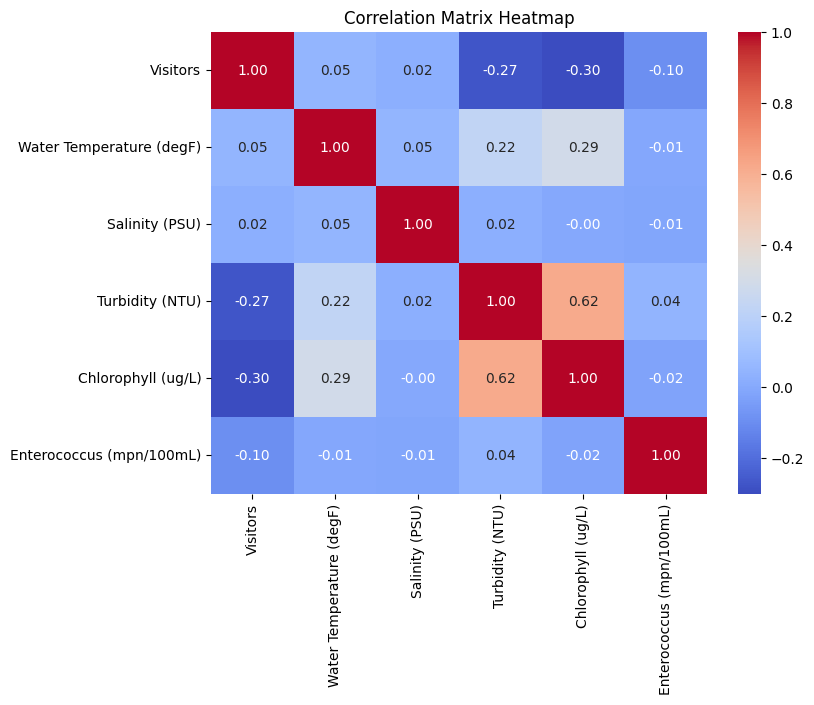

In [7]:
# Safe conversion: remove commas if present, then convert to numeric
tour['Visitors'] = tour['Visitors'].apply(lambda x: float(str(x).replace(',', '')) if pd.notnull(x) else x)

# Now select numeric columns
tour_data = tour.select_dtypes(include='number')

# Calculate correlation
tour_matrix = tour_data.corr()

# Plot heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(tour_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()

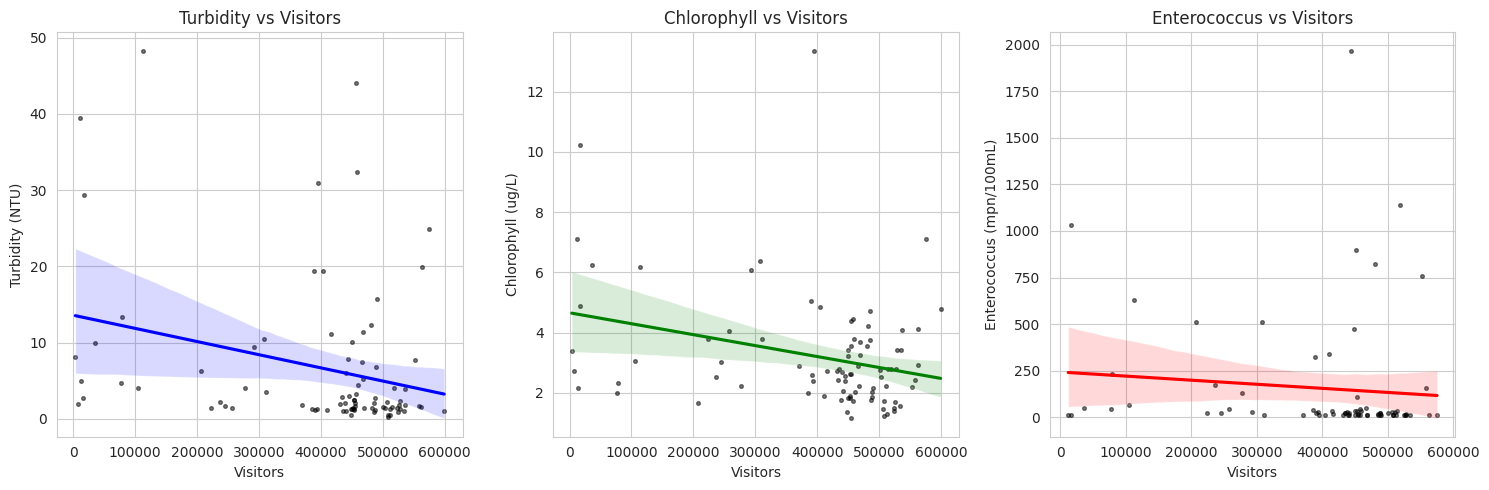

In [8]:
##regression plots

sns.set_style("whitegrid")
plt.figure(figsize=(15, 5))

# Turbidity vs Visitors
plt.subplot(1, 3, 1)
sns.regplot(x='Visitors', y='Turbidity (NTU)', data=tour, scatter_kws={'s': 7, 'alpha':0.5, 'color': 'black'}, line_kws={'color':'blue'})
plt.title('Turbidity vs Visitors')

# Chlorophyll vs Visitors
plt.subplot(1, 3, 2)
sns.regplot(x='Visitors', y='Chlorophyll (ug/L)', data=tour, scatter_kws={'s': 7, 'alpha':0.5, 'color': 'black'}, line_kws={'color':'green'})
plt.title('Chlorophyll vs Visitors')

# Enterococcus vs Visitors
plt.subplot(1, 3, 3)
sns.regplot(x='Visitors', y='Enterococcus (mpn/100mL)', data=tour, scatter_kws={'s': 7, 'alpha':0.5, 'color': 'black'}, line_kws={'color':'red'})
plt.title('Enterococcus vs Visitors')

plt.tight_layout()
plt.show()

In [9]:
# Convert date column
tour['year_month'] = pd.to_datetime(tour['year_month'])
tour = tour.set_index('year_month')

tour.head()

,Visitors,Water Temperature (degF),Salinity (PSU),Turbidity (NTU),Chlorophyll (ug/L),Enterococcus (mpn/100mL)
year_month,,,,,,
2018-01-01,NaN,79.891204,31.723171,1.919315,3.220971,NaN
2018-02-01,454308.0,79.309341,31.119680,1.639482,2.639715,NaN
2018-03-01,503033.0,79.152026,31.250279,1.481051,2.529561,NaN
2018-04-01,445058.0,80.045995,31.349549,3.003634,2.544006,NaN
2018-05-01,482224.0,79.881787,32.353888,1.395863,4.219175,NaN


In [10]:
y = tour['Turbidity (NTU)'] #change depending on var looking at
exog = tour[['Visitors']]

# Combine to avoid index mismatch
combo = pd.concat([y, exog], axis=1).dropna()

y_clean = combo.iloc[:,0]
exog_clean = combo.iloc[:,1:]

print(y_clean.shape, exog_clean.shape)

(87,) (87, 1)


In [11]:
##chlorophyll SARIMAX analysis

y = tour['Chlorophyll (ug/L)']
exog = tour[['Visitors']]

model_data = pd.concat([y, exog], axis=1).dropna()
y_clean = model_data['Chlorophyll (ug/L)']
exog_clean = model_data[['Visitors']]

model = SARIMAX(
    y_clean,
    exog=exog_clean,
    order=(1,1,1),              # ARIMA
    seasonal_order=(1,1,1,12),  # yearly seasonality
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit(disp=False)
print(results.summary())

/scratch/00713/kelly/miniforge3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/scratch/00713/kelly/miniforge3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                 Chlorophyll (ug/L)   No. Observations:                   87
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -148.055
Date:                            Mon, 08 Dec 2025   AIC                            308.110
Time:                                    21:36:21   BIC                            320.676
Sample:                                         0   HQIC                           313.026
                                             - 87                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Visitors     7.13e-07   8.36e-06      0.085      0.932   -1.57e-05    1.71e-05
ar.L1          0.6794      0.562   

/scratch/00713/kelly/miniforge3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [12]:
##turbidity SARIMAX analysis

y = tour['Turbidity (NTU)']
exog = tour[['Visitors']]

model_data = pd.concat([y, exog], axis=1).dropna()
y_clean = model_data['Turbidity (NTU)']
exog_clean = model_data[['Visitors']]

model = SARIMAX(
    y_clean,
    exog=exog_clean,
    order=(1,1,1),              # ARIMA
    seasonal_order=(1,1,1,12),  # yearly seasonality
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit(disp=False)
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                    Turbidity (NTU)   No. Observations:                   87
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -239.206
Date:                            Mon, 08 Dec 2025   AIC                            490.412
Time:                                    21:36:26   BIC                            502.978
Sample:                                         0   HQIC                           495.327
                                             - 87                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Visitors   -3.097e-06   2.09e-05     -0.148      0.882   -4.41e-05    3.79e-05
ar.L1          0.1839      0.276   

/scratch/00713/kelly/miniforge3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/scratch/00713/kelly/miniforge3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [13]:
##enterococcus SARIMAX analysis

y = tour['Enterococcus (mpn/100mL)']
exog = tour[['Visitors']]

model_data = pd.concat([y, exog], axis=1).dropna()
y_clean = model_data['Enterococcus (mpn/100mL)']
exog_clean = model_data[['Visitors']]

model = SARIMAX(
    y_clean,
    exog=exog_clean,
    order=(1,1,1),              # ARIMA
    seasonal_order=(1,1,1,12),  # yearly seasonality
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit(disp=False)
print(results.summary())

/scratch/00713/kelly/miniforge3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/scratch/00713/kelly/miniforge3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:           Enterococcus (mpn/100mL)   No. Observations:                   73
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -343.292
Date:                            Mon, 08 Dec 2025   AIC                            698.583
Time:                                    21:36:27   BIC                            709.555
Sample:                                         0   HQIC                           702.693
                                             - 73                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Visitors      -0.0003      0.001     -0.272      0.786      -0.002       0.002
ar.L1          0.0047      0.194   

In [14]:
## OLS regression

x_columns = ["Water Temperature (degF)", "Salinity (PSU)", "Turbidity (NTU)",
             "Chlorophyll (ug/L)", "Enterococcus (mpn/100mL)"]

# Select predictors and target
X = tour[x_columns].select_dtypes(include=[np.number])
y = tour["Visitors"]

# Replace infinite values with NaN
X = X.replace([np.inf, -np.inf], np.nan)
y = y.replace([np.inf, -np.inf], np.nan)

# Drop rows with any NaN values in X or y
mask = X.notna().all(axis=1) & y.notna()
X_clean = X[mask]
y_clean = y[mask]

X_clean = sm.add_constant(X_clean)

model = sm.OLS(y_clean, X_clean).fit()
print(model.summary())

### visitors

                            OLS Regression Results                            
Dep. Variable:               Visitors   R-squared:                       0.205
Model:                            OLS   Adj. R-squared:                  0.144
Method:                 Least Squares   F-statistic:                     3.358
Date:                Mon, 08 Dec 2025   Prob (F-statistic):            0.00928
Time:                        21:37:59   Log-Likelihood:                -937.25
No. Observations:                  71   AIC:                             1886.
Df Residuals:                      65   BIC:                             1900.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   